In [203]:
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
import math
from datetime import datetime  
from datetime import timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\warch\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
JB = pd.read_csv('./data/Lonely (with benny blanco)_incremental.csv')
series1 = JB['us']
series1.index = pd.to_datetime(JB['date'])
series1

date
2020-10-13         0
2020-10-14         0
2020-10-15         0
2020-10-16    964623
2020-10-17    719790
               ...  
2021-04-12    232824
2021-04-13    229428
2021-04-14    229968
2021-04-15    237418
2021-04-16    246129
Name: us, Length: 186, dtype: int64

In [164]:
def Arima_predict(dataset, title, test = True, periods_n = 60):
    if test:
        train = dataset[:int(len(dataset)*0.75)]
        test_data = dataset[int(len(dataset)*0.75):]
    else: 
        last_date = dataset.index[-1]
        indexes = [last_date + timedelta(days=i) for i in range(periods_n)]
    model = pm.auto_arima(train if test else dataset, start_p=0, d=1, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, max_d=5, # maximum p and q and d
                      m=12,              # frequency of series          
                      seasonal=True,
                      start_P=0, 
                      start_Q=0,
                      max_P=5, max_D=5, max_Q=5,
                      D=1, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=20,
                      n_fits=50)
    print(model.summary())
    prediction = model.predict(n_periods=len(test_data) if test else periods_n)
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    if test:
        plt.plot(train, label='training')
        plt.plot(test_data, label='actual')
    else:
        plt.plot(dataset, label = 'actual')
    plt.plot(pd.DataFrame(prediction,index = test_data.index if test else indexes), label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Number of streams')
    plt.title('Arima for: ' + title)
    plt.show()
    
def Prediction_time_series(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    
    Lmd1 = scaler.fit_transform(np.array(dataset).reshape(-1,1))
    Lmd2 = scaler.fit_transform(np.array(dataset.index).reshape(-1,1))
    train_size = int(len(Lmd1)*0.75)
    test_size = len(Lmd1) - train_size
    train, test = Lmd1[0:train_size,:], Lmd1[train_size:len(Lmd1),:]
    print('Train size, Test size:',len(train), len(test))
    look_back = 1
    trainY, testY  = Lmd1[0:train_size,:], Lmd1[train_size:len(Lmd1),:]
    trainX, testX = Lmd2[0:train_size,:], Lmd2[train_size:len(Lmd1),:]
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)
    
    testPredict = model.predict(testX)
    # invert predictions
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    testPredictPlot = np.empty_like(Lmd1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[train_size+1:len(Lmd1)-1, :] = testPredict
    # plot baseline and predictions
    plt.figure(figsize=(15,10))
    plt.plot(scaler.inverse_transform(Lmd1))
    #plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [160]:
def Autoregresion(dataset, title):
    X = dataset.values
    train, test = X[:int(len(X)*0.75)], X[int(len(X)*0.75):]
    rmse_Arr=[]
    try:
        for i in range(50):
            model = AutoReg(train, lags=i)
            model_fit = model.fit()
            model_fit.params
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
            rmse = math.sqrt(mean_squared_error(test, predictions))
            rmse_Arr.append(rmse)
    except:
        print(i)
    model = AutoReg(train, lags=rmse_Arr.index(min(rmse_Arr)))
    model_fit = model.fit()
    model_fit.params
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(dataset.index, X, label='true')
    plt.plot(dataset.index[len(train): len(train)+len(test)], predictions, label='predicted')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Number of streams')
    plt.title('Autoregression of: ' + title)

In [239]:
def Sarimax_model(dataset, title):
    X = dataset.values
    train, test = X[:int(len(X)*0.75)], X[int(len(X)*0.75):]
    rmse_Arr = []
    rmse_ind_Arr = []
    for i in range(5):
        for j in range(5):
            for k in range(5):
                try:
                    model = SARIMAX(train, order=(i, j, k), seasonal_order=(1,1,1,12))
                    model_fit = model.fit(disp=False)
                    # make prediction
                    predictions = model_fit.predict(len(train), len(test) + len(train)-1, dynamic=True)
                    #plt.figure()
                    #plt.plot(series_Lmd)
                    #plt.plot(series_Lmd.index[len(train):], yhat)
                    #plt.show()
                    rmse = math.sqrt(mean_squared_error(test, predictions))
                    rmse_Arr.append(rmse)
                    rmse_ind_Arr.append([i,j,k])
                except:
                    print(i,j,k)
    index = rmse_Arr.index(min(rmse_Arr))
    val = rmse_ind_Arr[index]
    model = SARIMAX(train, order=(val[0], val[1], val[2]), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)
    # make prediction
    predictions = model_fit.predict(len(train), len(test) + len(train)-1, dynamic=True)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(dataset.index, X, label='true')
    plt.plot(dataset.index[len(train): len(train)+len(test)], predictions, label='predicted')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Number of streams')
    plt.title('SARIMAX for: ' + title)


In [18]:
Chr = pd.read_csv('./data/All I Want for Christmas Is You_incremental.csv')
series_Chr = Chr['ca']
series_Chr.index = pd.to_datetime(pd.date_range('2017-11-20', '2021-01-15').tolist())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20181.314, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=19900.538, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=20175.389, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=19851.569, Time=2.21 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=19821.758, Time=5.28 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=19804.852, Time=10.51 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=19795.489, Time=21.03 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=65.41 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=36.47 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=19671.937, Time=20.66 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=19693.729, Time=9.11 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=77.05 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=31.73 sec
 ARIMA(0,1,1)(5,1,0)[12]    

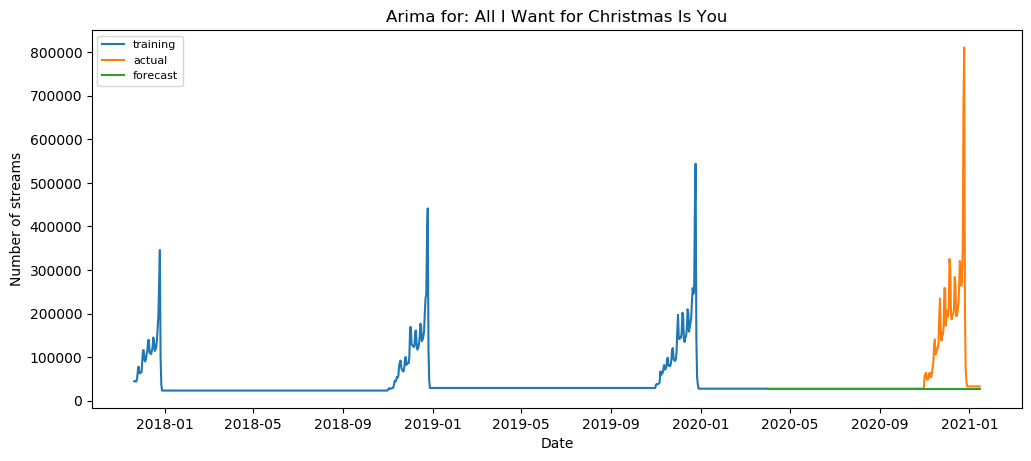

In [165]:
Arima_predict(series_Chr, 'All I Want for Christmas Is You')
#Arima_predict(series_Chr,test = False)

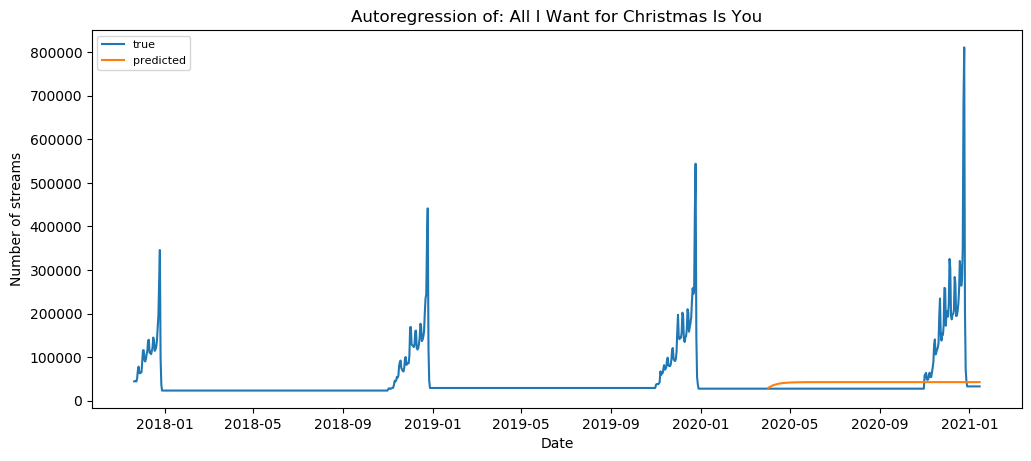

In [154]:
Autoregresion(series_Chr, 'All I Want for Christmas Is You')

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\state

1 3 3


C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\state

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\s

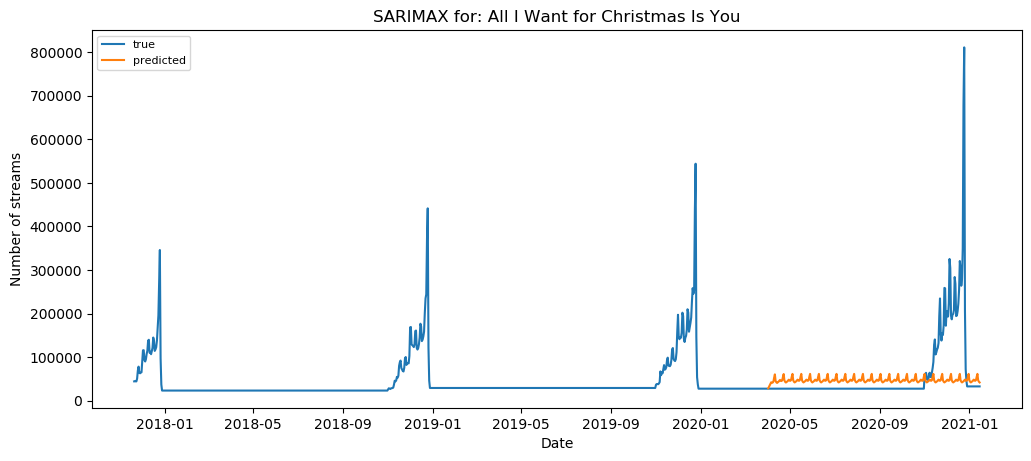

In [240]:
Sarimax_model(series_Chr, 'All I Want for Christmas Is You')

In [63]:
Lmd = pd.read_csv('./data/Lemonade (feat. Gunna, Don Toliver & NAV)_incremental.csv')
series_Lmd = Lmd['us']
series_Lmd.index = pd.to_datetime(Lmd['date'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4618.299, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4568.856, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4543.345, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4619.039, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4542.895, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4569.842, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4544.562, Time=2.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4544.558, Time=2.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4542.634, Time=0.89 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=4544.566, Time=1.73 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=4545.626, Time=4.46 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4543.546, Time=2.14 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=4512.212, Time=1.10 sec
 ARIMA(0,1,2)(0,1,1)[12]

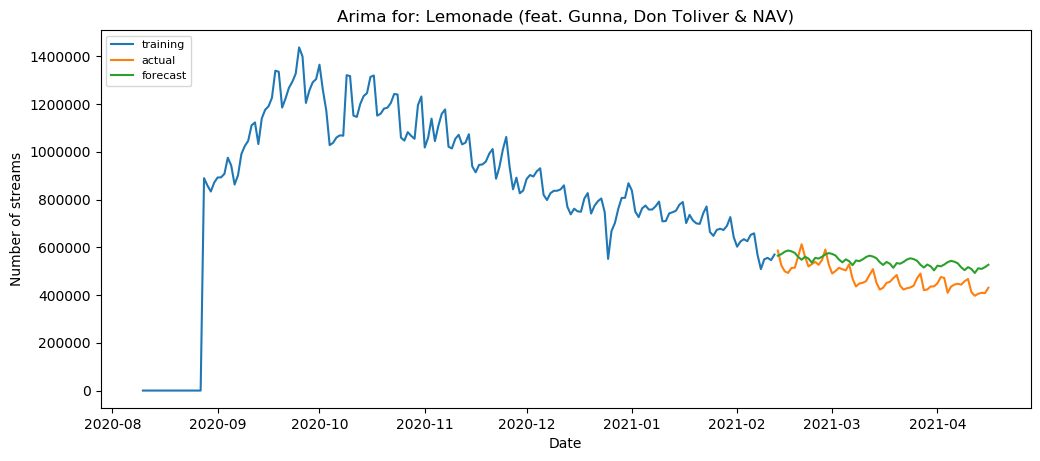

In [166]:
Arima_predict(series_Lmd, 'Lemonade (feat. Gunna, Don Toliver & NAV)')
#Arima_predict(series,test = False)

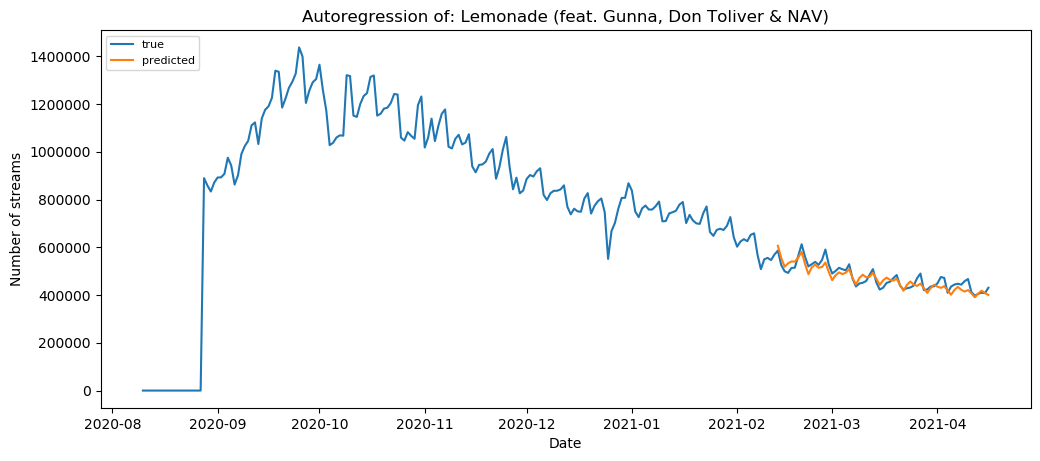

In [155]:
Autoregresion(series_Lmd, 'Lemonade (feat. Gunna, Don Toliver & NAV)')

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\state

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fa

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sari

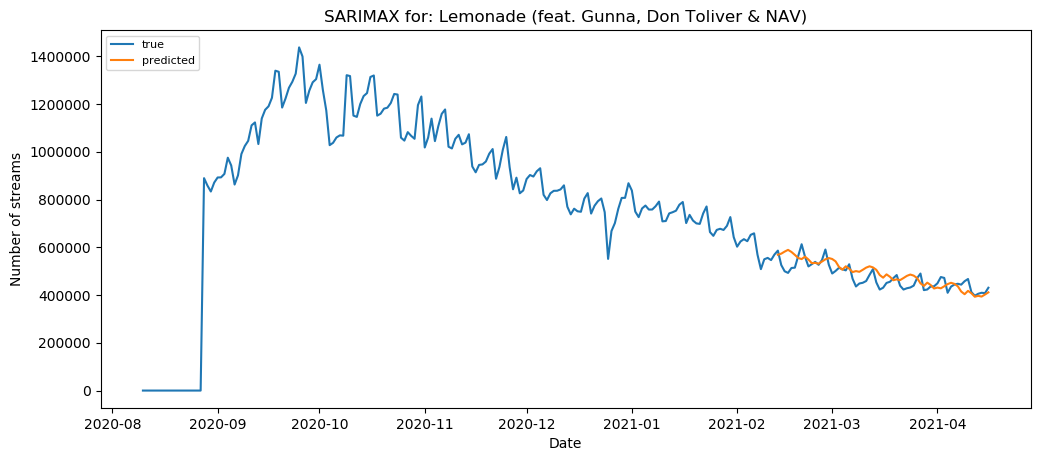

In [236]:
Sarimax_model(series_Lmd, 'Lemonade (feat. Gunna, Don Toliver & NAV)')

In [144]:
Fev = pd.read_csv('./data/Fever_incremental.csv')
series_Fev = Fev['fr']
series_Fev.index = pd.to_datetime(Fev['date'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2934.606, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2885.959, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2868.973, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2920.545, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2870.838, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2870.819, Time=0.65 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2881.973, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2862.388, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2862.568, Time=0.36 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2886.892, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2873.554, Time=0.29 sec
 ARIMA(1,1,1)(0,1,1)[12]          

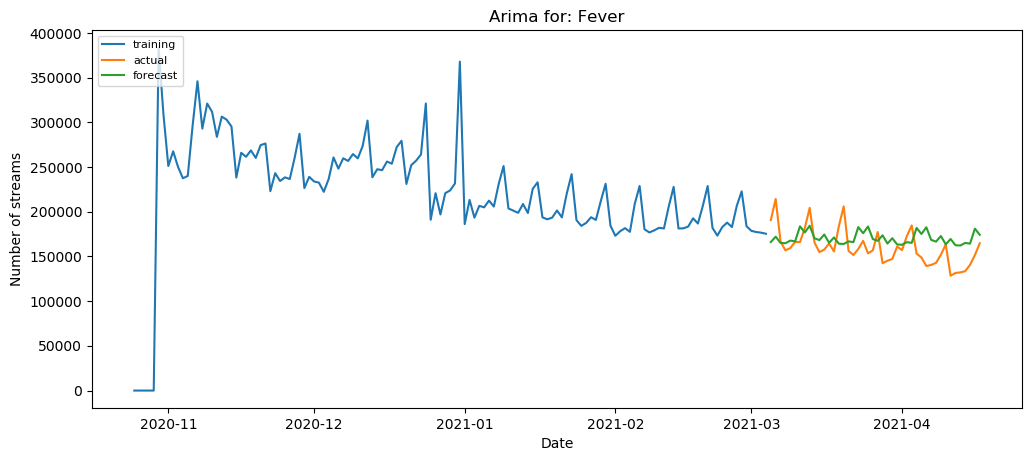

In [167]:
Arima_predict(series_Fev, 'Fever')
#Arima_predict(series_Fev,test = False)

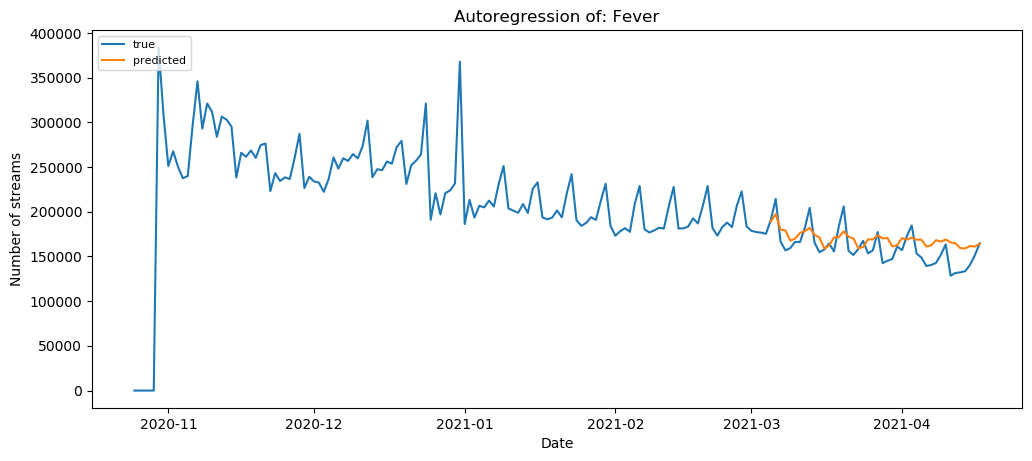

In [156]:
Autoregresion(series_Fev, 'Fever')

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible star

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarnin

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sari

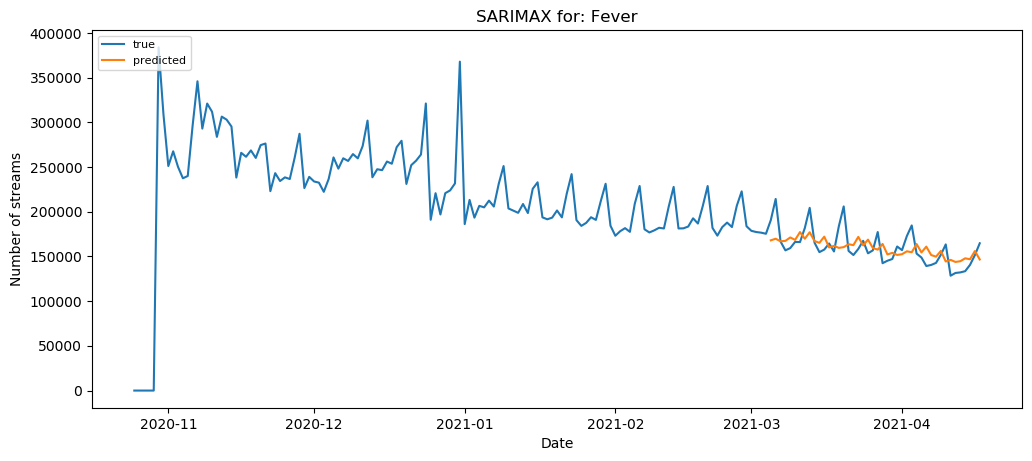

In [235]:
Sarimax_model(series_Fev, 'Fever')

In [146]:
OR = pd.read_csv('./data/drivers license_incremental.csv')
series_OR = OR['us']
series_OR.index = pd.to_datetime(OR['date'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1919.219, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1857.710, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1860.884, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1888.261, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1857.053, Time=0.49 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1858.708, Time=0.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1858.421, Time=0.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1856.423, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1856.132, Time=0.17 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1856.577, Time=0.38 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1858.422, Time=0.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1858.281, Time=0.27 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1856.694, Time=0.30 sec
 ARIMA(2,1,1)(0,1,1)[12]

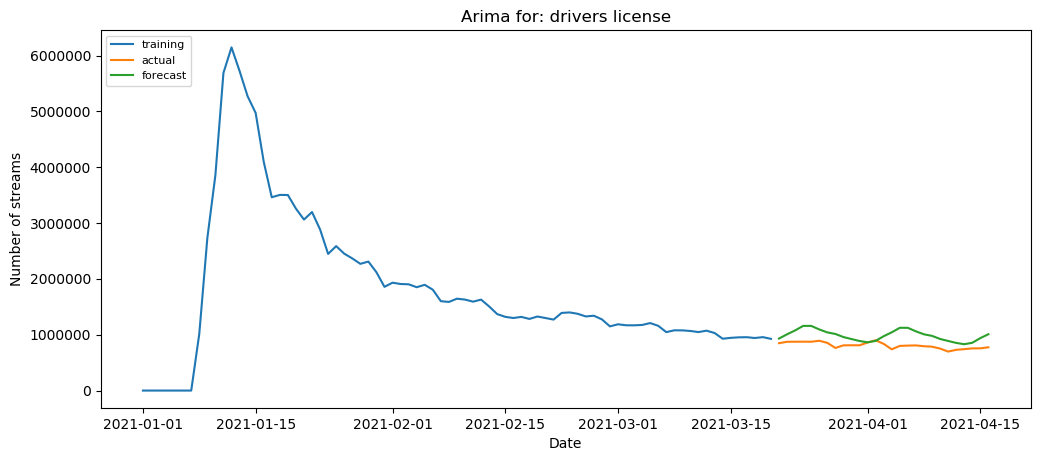

In [168]:
Arima_predict(series_OR, 'drivers license')
#Arima_predict(series2,test = False)

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


39


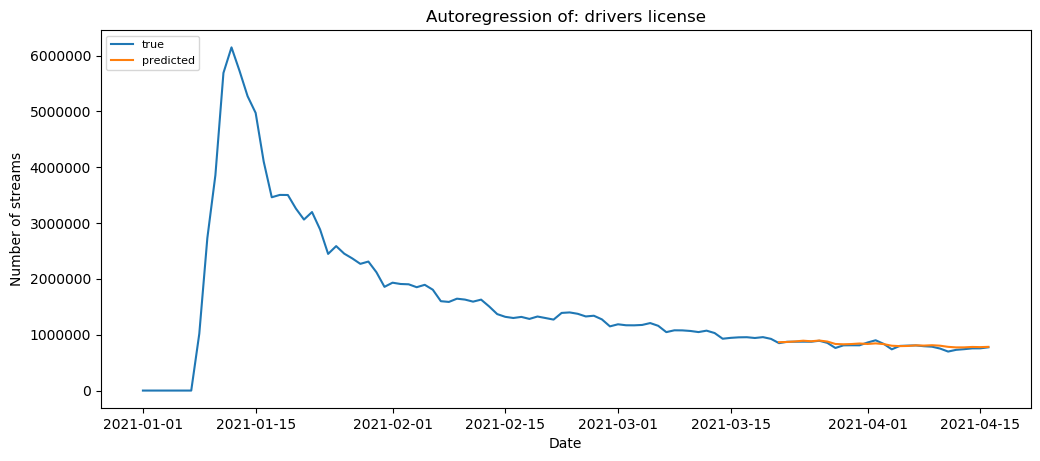

In [157]:
Autoregresion(series_OR, 'drivers license')

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserW

C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\warch\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum

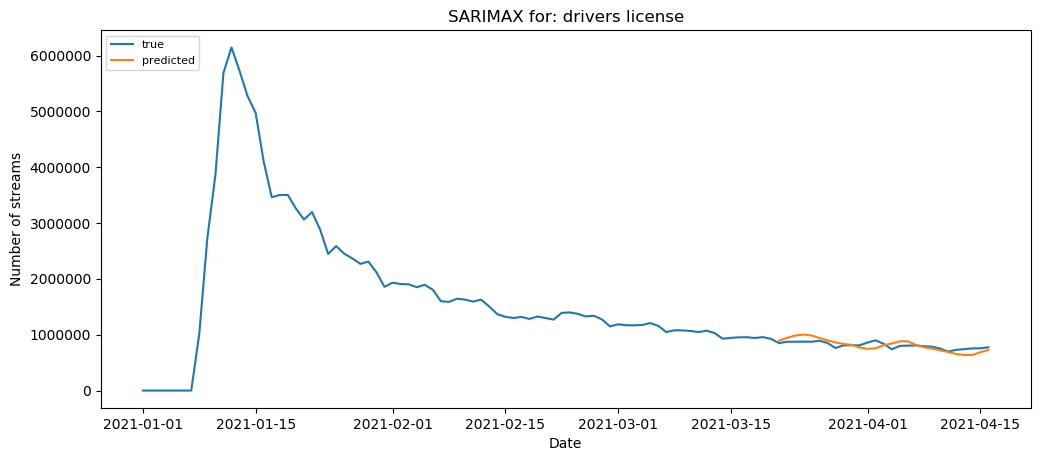

In [237]:
Sarimax_model(series_OR, 'drivers license')